In [27]:
%load_ext autoreload
%autoreload 2     

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import warnings
import random

# OP simulator configuration
from voting_mechanism_design.legacy.op_simulator import Simulation as OPSimulation
from voting_mechanism_design.legacy.op_simulator import Voter as OPVoter
from voting_mechanism_design.legacy.op_simulator import Project as OPProject


In [29]:
def create_badgeholders(
    n_badgeholders,
    total_funds,
    min_vote,
    max_vote,
    badgeholder_expertise_vec,
    badgeholder_laziness_vec,
    expertise_model
):
    badgeholders_n = []
    badgeholders_o = []
    for ii in range(n_badgeholders):
        agent = QuorumBadgeholder(
            badgeholder_id=ii,
            total_funds=total_funds,
            min_vote=min_vote,  
            max_vote=max_vote,
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
            coi_factor=0,
            expertise_model="carl"
        )
        agent2 = OPVoter(
            voter_id = ii,
            op_available=total_funds, 
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
        )
        badgeholders_n.append(agent)
        badgeholders_o.append(agent2)        
    return badgeholders_n,badgeholders_o

def create_projects(n_projects,project_impact_vec):
    projects_n = []
    projects_o = []
    for ii in range(n_projects):
        project = Project(
            project_id=ii,
            true_impact=project_impact_vec[ii],  
            owner_id=None,  
        )
        project2 = OPProject(
            project_id=ii,
            rating=project_impact_vec[ii],
            owner_id=None,  # No COI modeling here
        )
        projects_n.append(project)
        projects_o.append(project2)
    return projects_n,projects_o

def single_sim_old(badgeholders,projects,q,scoring_fn,total_funds,min_amount,n_projects):
    simulation=OPSimulation()
    simulation.initialize_round(max_funding=total_funds)
    simulation.round.add_voters(badgeholders)
    simulation.round.add_projects(projects)
    results = simulation.simulate_voting_and_scoring(
        n=total_funds,
        scoring_method=scoring_fn,
        quorum=q,
        min_amount=min_amount,
        normalize=False
    )
    return results

def single_sim_new(badgeholders,projects):
    badgeholder_pop=QuorumBadgeholderPopulation()
    project_population = ProjectPopulation()
    fund_distribution_model = ThresholdAndAggregate()

    badgeholder_pop.add_badgeholders(badgeholders)
    project_population.add_projects(projects)
    
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholder_pop,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    return simulation_obj


def extract_old(results):
    project_data = results['data']
    project_funds_df = pd.DataFrame({
        'Project Id': [project['project_id'] for project in project_data],
        'Total Funds': [round(project['token_amount'] , 10) for project in project_data]
    })
    return project_funds_df

def extract_new(results):
    project_population = results.projects
    project_vote_counts = defaultdict(int)
    for project in project_population.get_projects():
        for vote in project.votes:
            project_vote_counts[project.project_id] += round(vote.amount if vote.amount is not None else 0, 10)
    project_funds_df = pd.DataFrame({
        'Project Id': list(project_vote_counts.keys()),
        'Total Funds': list(project_vote_counts.values())
    })
    return project_funds_df


def plot_comparison_histograms(old_results, new_results):
    # Add framework labels
    old['Framework'] = 'Old'
    new['Framework'] = 'New'
    
    # Ensure both DataFrames have the same set of Project IDs
    combined_project_ids = pd.Series(list(set(old['Project Id']).union(set(new['Project Id'])))).sort_values()

    # Merge old and new DataFrames on Project Id to align them
    merged_df = pd.merge(old, new, on='Project Id', how='outer', suffixes=('_Old', '_New')).fillna(0)

    # Calculate the differences
    merged_df['Total Funds_Difference'] = merged_df['Total Funds_Old'] - merged_df['Total Funds_New']

    # Set the width of the bars
    bar_width = 0.25

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(merged_df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(14, 18))

    # Plot old framework results
    axs[0].bar(r1, merged_df['Total Funds_Old'], color='blue', width=bar_width, edgecolor='grey', label='Old Framework')
    axs[0].set_xlabel('Project ID', fontweight='bold')
    axs[0].set_ylabel('Total Funds')
    axs[0].set_title('Total Funds Received by Each Project (Old Framework)')
    axs[0].legend()
    axs[0].set_xticks([r + bar_width for r in range(len(merged_df))])
    axs[0].set_xticklabels(merged_df['Project Id'])

    # Plot new framework results
    axs[1].bar(r2, merged_df['Total Funds_New'], color='green', width=bar_width, edgecolor='grey', label='New Framework')
    axs[1].set_xlabel('Project ID', fontweight='bold')
    axs[1].set_ylabel('Total Funds')
    axs[1].set_title('Total Funds Received by Each Project (New Framework)')
    axs[1].legend()
    axs[1].set_xticks([r + bar_width for r in range(len(merged_df))])
    axs[1].set_xticklabels(merged_df['Project Id'])

    # Plot the differences
    axs[2].bar(r3, merged_df['Total Funds_Difference'], color='red', width=bar_width, edgecolor='grey', label='Difference (Old - New)')
    axs[2].set_xlabel('Project ID', fontweight='bold')
    axs[2].set_ylabel('Difference in Total Funds')
    axs[2].set_title('Difference in Total Funds Received by Each Project (Old - New)')
    axs[2].legend()
    axs[2].set_xticks([r for r in range(len(merged_df))])
    axs[2].set_xticklabels(merged_df['Project Id'])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
def sim_frameworks(
    n_badgeholders=10,
    total_funds=100,
    min_vote=1,
    max_vote=16,
    n_projects=100,
    q=0,
    scoring_fn=['mean'],
    badgeholder_expertise_vec=None,
    badgeholder_laziness_vec=None,
    project_impact_vec=None,
    expertise_model="carl"
):
    random.seed(42)
    np.random.seed(42)
    if badgeholder_expertise_vec.all()==None:
        badgeholder_expertise_vec=np.ones(n_badgeholders)
    if badgeholder_laziness_vec.all()==None:
            badgeholder_laziness_vec=np.zeros(n_badgeholders)
    if project_impact_vec.all()==None:
        project_impact_vec=np.ones(n_projects)

    badgeholders_n,badgeholders_o=create_badgeholders(
        n_badgeholders,
        total_funds,
        min_vote,
        max_vote,
        badgeholder_expertise_vec,
        badgeholder_laziness_vec,
        expertise_model
    )
    projects_n,projects_o=create_projects(n_projects,project_impact_vec)
    old_results=single_sim_old(badgeholders_o,projects_o,q,scoring_fn,total_funds,min_vote,n_projects)
    new_results=single_sim_new(badgeholders_n,projects_n)
    return old_results,new_results

def compare_rankings(old, new, detail):
    # Sort old and new DataFrames by Total Funds in descending order
    old_sorted = old.sort_values(by='Total Funds', ascending=False).reset_index(drop=True)
    new_sorted = new.sort_values(by='Total Funds', ascending=False).reset_index(drop=True)

    # Extract the rankings based on Project Id
    old_ranking = old_sorted['Project Id'].tolist()
    new_ranking = new_sorted['Project Id'].tolist()

    # Check if the rankings match
    rankings_match = old_ranking == new_ranking

    # Print the rankings
    if detail==True:
        print("Old Framework Ranking Project ID (Highest to Lowest):", old_ranking)
        print("New Framework Ranking Project ID (Highest to Lowest):", new_ranking)

    # Print whether the rankings match
    if rankings_match:
        print("The rankings match between the old and new frameworks.")
        return True
    else:
        print("The rankings do not match between the old and new frameworks.")
        
        # Highlight mismatches
        print("\nDifferences in Rankings:")
        rank_changes = {}
        for i, project_id in enumerate(old_ranking):
            old_position = i + 1
            new_position = new_ranking.index(project_id) + 1
            if old_position != new_position:
                #print(f"Project ID {project_id}: Old Rank = {old_position}, New Rank = {new_position}")
                rank_changes[project_id] = new_position - old_position

        # Count of changes
        total_changes = len(rank_changes)
        print(f"\nTotal number of projects with rank changes: {total_changes}")

        # Maximum rank change
        if rank_changes:
            max_change_project = max(rank_changes, key=lambda k: abs(rank_changes[k]))
            max_change = rank_changes[max_change_project]
            print(f"\nProject with the maximum rank change: Project ID {max_change_project}")
            print(f"Maximum rank change: {max_change} positions (Old Rank = {old_ranking.index(max_change_project) + 1}, New Rank = {new_ranking.index(max_change_project) + 1})")
        return False
    # Return the rankings for further use if needed
    #return rankings_match

In [30]:
#Variable Parameters
n_badgeholders=10
total_funds=100
min_vote=1
max_vote=16
badgeholder_expertise_vec=np.ones(n_badgeholders)
badgeholder_laziness_vec=np.zeros(n_badgeholders)
n_projects=100
project_impact_vec=np.ones(n_projects)
q=0
scoring_fn=['mean']

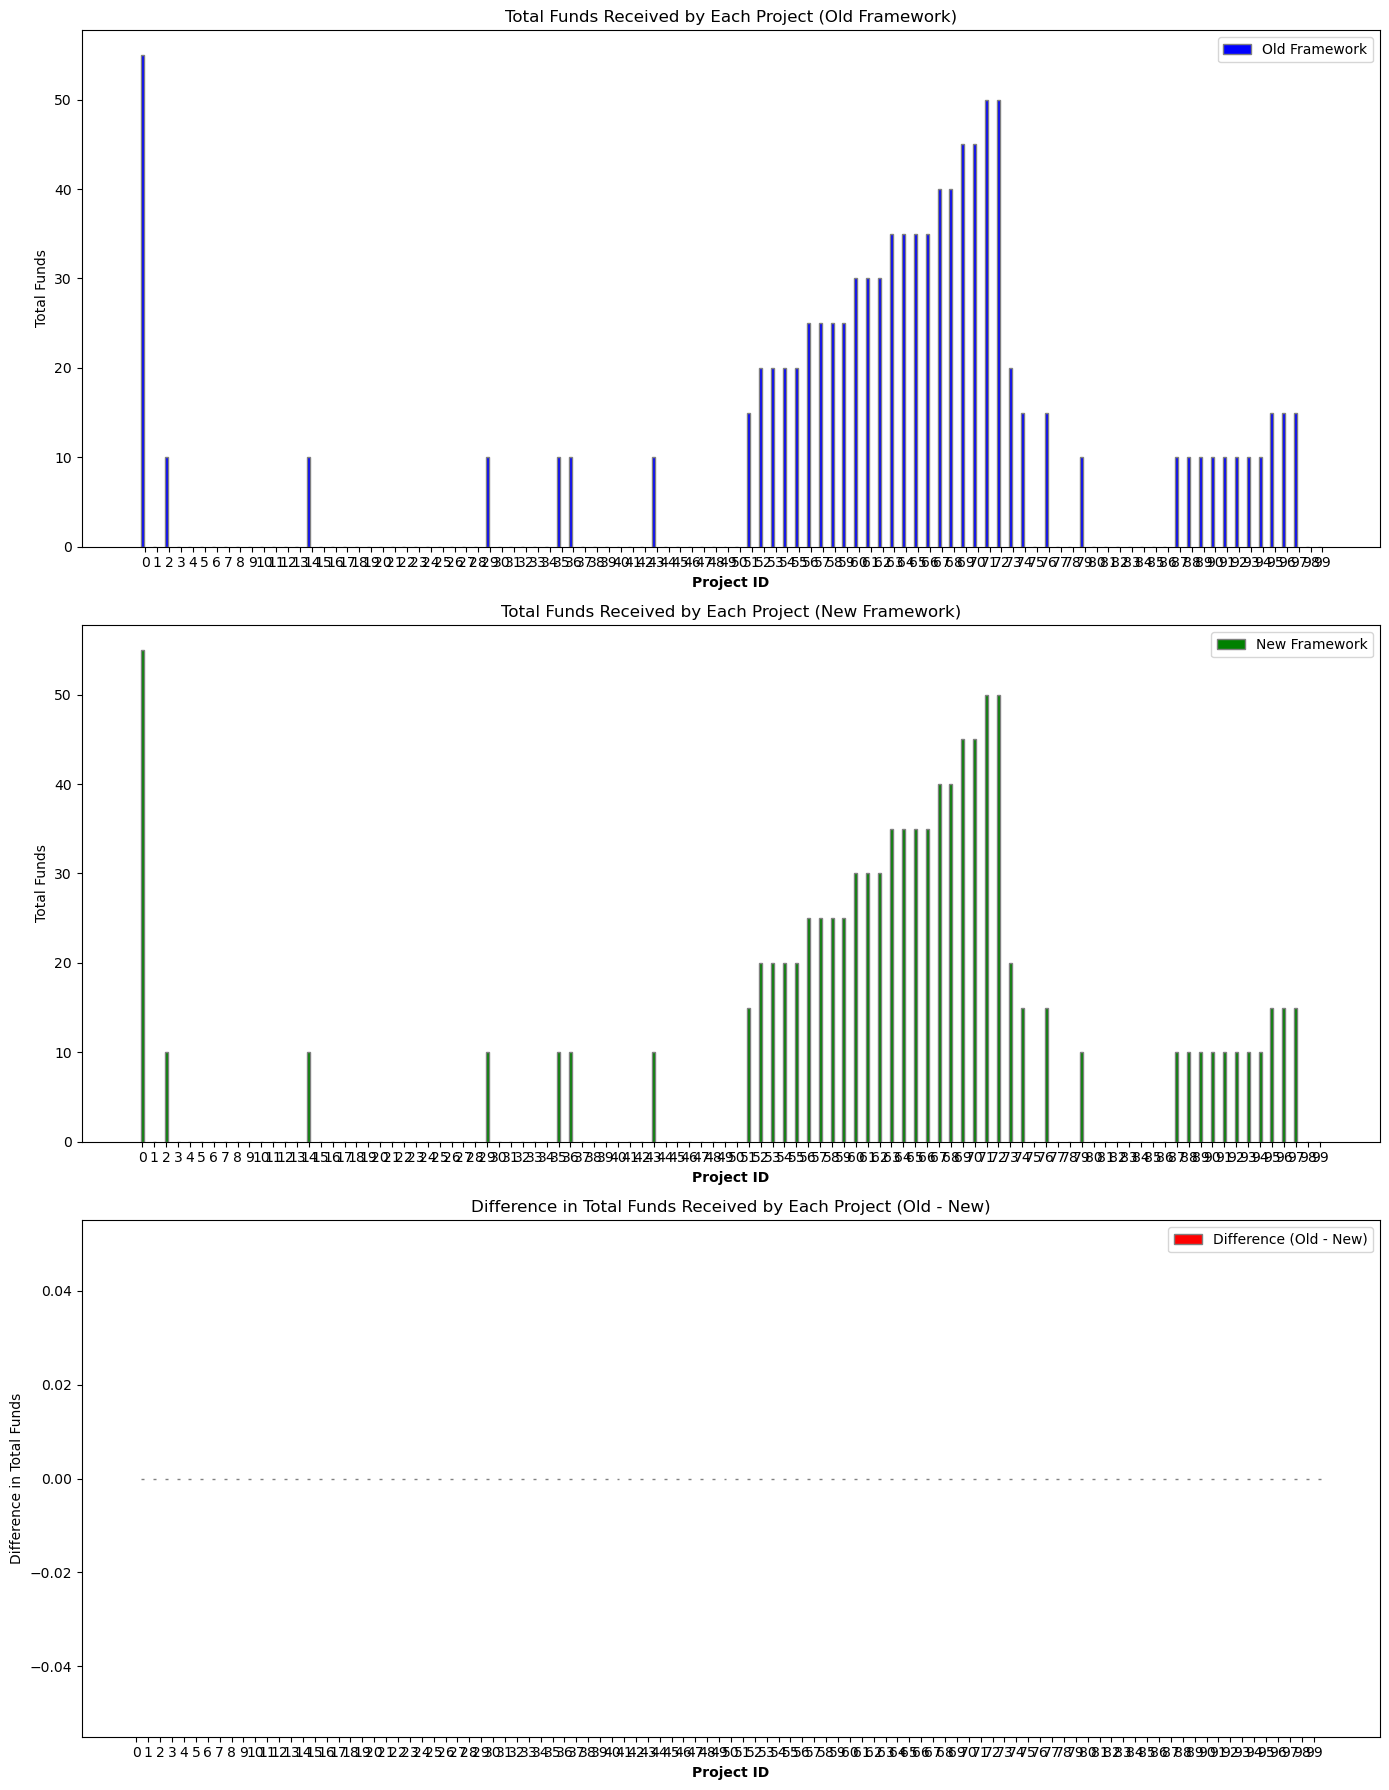

The rankings match between the old and new frameworks.


True

In [31]:
old_results,new_results=sim_frameworks(
    n_badgeholders=n_badgeholders,
    total_funds=total_funds,
    min_vote=min_vote,
    max_vote=max_vote,
    badgeholder_expertise_vec=badgeholder_expertise_vec,
    badgeholder_laziness_vec=badgeholder_laziness_vec,
    n_projects=n_projects,
    project_impact_vec=project_impact_vec,
    q=q,
    scoring_fn=scoring_fn,
    expertise_model="carl"
)
old=extract_old(old_results)
new=extract_new(new_results)
plot_comparison_histograms(old,new)
compare_rankings(old, new, False)
#print(old,new)

In [17]:
#####testing
def get_votes_for_project(project_population, target_project_id):
    project = project_population.get_project(target_project_id)
    if project is None:
        raise ValueError(f"Project with ID {target_project_id} does not exist.")
    vote_amounts = [vote.amount for vote in project.votes if vote.amount is not None]
    return vote_amounts

project_population = new_results.projects
target_project_id = 0

votes_for_project_0 = get_votes_for_project(project_population, target_project_id)
print(f"Votes for project ID {target_project_id}: {votes_for_project_0}")



#print(old_results)
#print("hi")
#print(new_results)

Votes for project ID 0: [5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5]


#test variable inputs

In [18]:
np.random.seed(42)

n_badgeholders_stress_test=(10,50,100,200)
total_funds_stress_test=(10,100,500)
badgeholder_expertise_vec_stress_test=[np.random.rand(n_badgeholders) for i in range(3)]
badgeholder_laziness_vec_stress_test=[np.random.rand(n_badgeholders) for i in range(3)]
project_impact_vec_stress_test=[np.random.rand(n_badgeholders) for i in range(3)]

experiment_cfgs = list(itertools.product(n_badgeholders_stress_test, total_funds_stress_test, badgeholder_expertise_vec_stress_test, badgeholder_laziness_vec_stress_test, project_impact_vec_stress_test))

for experiment_cfg in tqdm(experiment_cfgs):
    n_badgeholders, total_funds, badgeholder_expertise_val, badgeholder_laziness_val, project_impact_val = experiment_cfg
    
    old,new=sim_frameworks(
        n_badgeholders=n_badgeholders,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        q=q,
        scoring_fn=scoring_fn,
    expertise_model="carl"
    )
    old=extract_old(old_results)
    new=extract_new(new_results)
    rankings_match=compare_rankings(old, new, False)
    if rankings_match==False:
        print(f"n_badgeholders,total_funds,badgeholder_expertise_vec,badgeholder_laziness_vec,project_impact_vec")

  1%|▌                                                                                 | 2/324 [00:00<00:34,  9.35it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  2%|█▎                                                                                | 5/324 [00:00<00:45,  7.04it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  2%|█▊                                                                                | 7/324 [00:00<00:40,  7.77it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  2%|██                                                                                | 8/324 [00:01<00:40,  7.78it/s]

The rankings match between the old and new frameworks.


  3%|██▌                                                                              | 10/324 [00:01<00:48,  6.44it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  4%|███                                                                              | 12/324 [00:01<00:42,  7.37it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  4%|███▎                                                                             | 13/324 [00:01<00:39,  7.80it/s]

The rankings match between the old and new frameworks.


  5%|████                                                                             | 16/324 [00:02<00:41,  7.38it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  6%|████▌                                                                            | 18/324 [00:02<00:39,  7.81it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  6%|█████▎                                                                           | 21/324 [00:02<00:34,  8.66it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  7%|█████▊                                                                           | 23/324 [00:02<00:33,  9.05it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  8%|██████▌                                                                          | 26/324 [00:03<00:31,  9.41it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  8%|██████▊                                                                          | 27/324 [00:03<00:38,  7.73it/s]

The rankings match between the old and new frameworks.


  9%|███████                                                                          | 28/324 [00:04<01:50,  2.68it/s]

The rankings match between the old and new frameworks.


  9%|███████▎                                                                         | 29/324 [00:05<02:58,  1.65it/s]

The rankings match between the old and new frameworks.


  9%|███████▌                                                                         | 30/324 [00:07<03:48,  1.29it/s]

The rankings match between the old and new frameworks.


 10%|███████▊                                                                         | 31/324 [00:08<04:14,  1.15it/s]

The rankings match between the old and new frameworks.


 10%|████████                                                                         | 32/324 [00:09<04:42,  1.03it/s]

The rankings match between the old and new frameworks.


 10%|████████▎                                                                        | 33/324 [00:10<04:57,  1.02s/it]

The rankings match between the old and new frameworks.


 10%|████████▌                                                                        | 34/324 [00:11<05:23,  1.12s/it]

The rankings match between the old and new frameworks.


 11%|████████▊                                                                        | 35/324 [00:13<05:34,  1.16s/it]

The rankings match between the old and new frameworks.


 11%|█████████                                                                        | 36/324 [00:14<05:31,  1.15s/it]

The rankings match between the old and new frameworks.


 11%|█████████▎                                                                       | 37/324 [00:15<05:28,  1.14s/it]

The rankings match between the old and new frameworks.


 12%|█████████▌                                                                       | 38/324 [00:16<05:40,  1.19s/it]

The rankings match between the old and new frameworks.


 12%|█████████▊                                                                       | 39/324 [00:17<05:36,  1.18s/it]

The rankings match between the old and new frameworks.


 12%|█████████▊                                                                       | 39/324 [00:18<02:13,  2.14it/s]


KeyboardInterrupt: 

In [19]:
np.random.seed(42)

n_badgeholders_stress_test = (10, 50, 100, 200)
total_funds_stress_test = (10, 100, 500)

# Generating pseudo-random vectors for stress tests
max_badgeholders= max(n_badgeholders_stress_test)
#badgeholder_expertise_vec_stress_test = [np.random.rand(max_badgeholders) for _ in range(3)]#change function for this temp
#badgeholder_laziness_vec_stress_test = [np.random.rand(max_badgeholders) for _ in range(3)]
#project_impact_vec_stress_test = [np.random.rand(max_badgeholders) for _ in range(3)]
badgeholder_expertise_vec_stress_test = list(np.linspace(0,1,4))
badgeholder_laziness_vec_stress_test = list(np.linspace(0,1,4))
project_impact_vec_stress_test = list(np.linspace(0,1,4))

experiment_cfgs = list(itertools.product(n_badgeholders_stress_test, total_funds_stress_test, badgeholder_expertise_vec_stress_test, badgeholder_laziness_vec_stress_test, project_impact_vec_stress_test))

for experiment_cfg in tqdm(experiment_cfgs):
    n_badgeholders, total_funds, badgeholder_expertise_val, badgeholder_laziness_val, project_impact_val = experiment_cfg
    
    badgeholder_expertise_vec= np.ones(max_badgeholders) * badgeholder_expertise_val
    badgeholder_laziness_vec= np.ones(max_badgeholders) * badgeholder_laziness_val
    project_impact_vec= np.ones(max_badgeholders) * project_impact_val
    
    old, new = sim_frameworks(
        n_badgeholders=n_badgeholders,
        total_funds=total_funds,
        min_vote=min_vote,
        max_vote=max_vote,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        q=q,
        scoring_fn=scoring_fn,
    expertise_model="carl"
    )
    old=extract_old(old_results)
    new=extract_new(new_results)
    rankings_match=compare_rankings(old, new, False)
    if rankings_match==False:
        print(f"Configuration:\n"
              f"- Number of Badgeholders: {n_badgeholders}\n"
        f"- Total Funds: {total_funds}\n"
        f"- Badgeholder Expertise Vector: {badgeholder_expertise_vec}\n" #ok so i want to change this so it print which vector list, not the whole list
        f"- Badgeholder Laziness Vector: {badgeholder_laziness_vec}\n"
        f"- Project Impact Vector: {project_impact_vec}\n")


  0%|▏                                                                                 | 2/768 [00:00<01:18,  9.75it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  1%|▍                                                                                 | 4/768 [00:00<01:27,  8.69it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  1%|▋                                                                                 | 6/768 [00:00<01:23,  9.09it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  1%|▊                                                                                 | 8/768 [00:00<01:18,  9.69it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  1%|█                                                                                | 10/768 [00:01<01:14, 10.17it/s]

The rankings match between the old and new frameworks.


  2%|█▎                                                                               | 12/768 [00:01<03:01,  4.18it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


C:\Users\Martingale Guest\anaconda3\envs\quorum-voting-env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Martingale Guest\anaconda3\envs\quorum-voting-env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|█▋                                                                               | 16/768 [00:02<01:49,  6.87it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  2%|█▉                                                                               | 18/768 [00:02<01:39,  7.51it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  3%|██                                                                               | 20/768 [00:02<01:36,  7.72it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  3%|██▏                                                                              | 21/768 [00:02<01:51,  6.73it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  3%|██▋                                                                              | 26/768 [00:03<01:21,  9.06it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  4%|██▉                                                                              | 28/768 [00:03<01:15,  9.77it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  4%|███▍                                                                             | 32/768 [00:03<01:02, 11.80it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  4%|███▌                                                                             | 34/768 [00:04<01:15,  9.67it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  5%|███▊                                                                             | 36/768 [00:04<01:17,  9.45it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  5%|████                                                                             | 38/768 [00:04<01:16,  9.53it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  5%|████▏                                                                            | 40/768 [00:04<01:14,  9.82it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  5%|████▍                                                                            | 42/768 [00:05<01:22,  8.78it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  6%|████▊                                                                            | 46/768 [00:05<01:20,  8.97it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  6%|█████                                                                            | 48/768 [00:05<01:20,  8.99it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  7%|█████▎                                                                           | 50/768 [00:06<01:23,  8.64it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  7%|█████▍                                                                           | 52/768 [00:06<01:27,  8.23it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  7%|█████▋                                                                           | 54/768 [00:06<01:23,  8.56it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  7%|█████▊                                                                           | 55/768 [00:06<01:21,  8.71it/s]

The rankings match between the old and new frameworks.


  8%|██████                                                                           | 58/768 [00:07<01:33,  7.60it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  8%|██████▋                                                                          | 63/768 [00:07<01:05, 10.79it/s]

The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.
The rankings match between the old and new frameworks.


  8%|██████▊                                                                          | 65/768 [00:08<03:31,  3.32it/s]

The rankings match between the old and new frameworks.


  9%|██████▉                                                                          | 66/768 [00:10<05:52,  1.99it/s]

The rankings match between the old and new frameworks.


  9%|███████                                                                          | 67/768 [00:11<07:38,  1.53it/s]

The rankings match between the old and new frameworks.


  9%|███████                                                                          | 67/768 [00:11<02:05,  5.59it/s]


KeyboardInterrupt: 